# Using Dropout to fight overfitting

**Goal:** In this notebook you will learn how you can use dropout layers as a very easy way to fight overfitting. You will download the cifar10 dataset which contains quite small images (32x32x3) of 10 classes. The data is from the Canadian Institute For Advanced Research. You will plot examples of the images with the class label below. Note that because the images are so small it's not always very easy to recoginse which of the ten classes is on the iamge, even as a human. After loading the dataset you will train two Convolutional neural networks to predict the the test dataset.   
The first Convolutional neural network will have no dropout layers.  
The second neural network will use dropout layers in the fully connected part of the network.

Finall, you will see that dropout during training is a very easy way to prevent overfitting and even to improve the accuracy!

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it. 

**Dataset:** You work with the Cifar10 dataset. You have 60'000 32x32 pixel color images of 10 classes ("airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck")

**Content:**
* Load the Cifar10 dataset
* Plot a random example of each class label
* Normalize the data to be in the range from -1 and 1
* Define and fit a Convolutional neural network without any dropout layers
* Define and fit a Convolutional neural network with dropout layers in the fully connected part
* Compare the loss and accuracy curves of the two models 

| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_08/nb_ch08_02.ipynb)


In [6]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

In [7]:
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.8.2  running in colab?:  True


In [8]:
if IN_COLAB:
    !pip install tensorflow_probability==0.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 32.3 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=242d03271c6d85e1bc538660e3ef5098cfcdd1c9e5e234c1e39d2749cf2a96ff
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 1.3.0
    Uninstalling cloudpickle-1.3.0:
      Successfully uninstalled cloudpickle-1.3.0
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.16.0
    Uninstalling tensorflow-probability-0.16.0:
      Successfully uninstalled tensorflow-probability-0.16.0
ERROR: pip's dependency resolver

#### Imports


In [9]:
# load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Dropout
from tensorflow.keras.utils import to_categorical 


### Load, plot and normalize the data

In the next cell you will load the Cifar10 dataset, 50'000 images are in the training set and 10'000 are in the test dataset.
You will plot one random example of each label, as you can see the images are really small. After the ploting you normalize the images which are in the range from 0 to 255 to be in the range of -1 to 1. Finally you can convert the lables into the one hot encoding.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


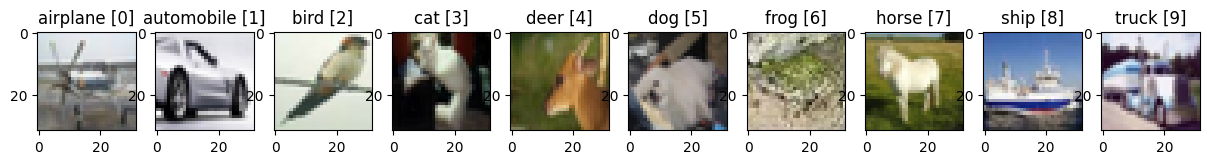

In [10]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

labels=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])
#sample image of each label
plt.figure(figsize=(15,15))
for i in range(0,len(np.unique(y_train))):
    rmd=np.random.choice(np.where(y_train==i)[0],1)
    plt.subplot(1,10,i+1)
    img=x_train[rmd]
    plt.imshow(img[0,:,:,:])
    plt.title(labels[i]+" "+np.str(y_train[rmd][0]))


X_train=((x_train / 255)-0.5)*2 # normalize the data into a range from -1 to 1
Y_train=tensorflow.keras.utils.to_categorical(y_train,10) # one-hot encoding

X_test=((x_test / 255)-0.5)*2   # normalize the data into a range from -1 to 1
Y_test=tensorflow.keras.utils.to_categorical(y_test,10) # one-hot encoding



In [11]:
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


## Define and fit a CNN without dropout layers

In the next few cells you will define and train a CNN to classify the images into the 10 classes. You will use a network with 2 Convolution blocks followed by a Maxpooling layer. After the feature extraction part you will use 2 fully connected layers before classifying the image into one of the 10 classes. You can lookup the hyperparameters of the CNN in the cell below.

In [12]:
# here you define hyperparameter of the CNN
batch_size = 128
img_rows, img_cols = 32, 32
kernel_size = (3, 3)
input_shape = (img_rows, img_cols, 3)
pool_size = (2, 2)

#### Listing 8.4 Defining and training of a classification CNN with dropout layers

In [13]:
nb_classes = 10

# define CNN with 2 convolution blocks and 2 fully connected layers
model = Sequential()

model.add(Convolution2D(16,kernel_size,padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(16,kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Convolution2D(32,kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(32,kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))


model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 activation (Activation)     (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        4640      
                                                        

In [15]:
history1=model.fit(X_train, Y_train,validation_data=(X_test,Y_test), batch_size=128,epochs=30,verbose=1)


Epoch 1/30
391/391 [==============================] - 17s 9ms/step - loss: 1.4959 - accuracy: 0.4589 - val_loss: 1.2130 - val_accuracy: 0.5630
Epoch 2/30
391/391 [==============================] - 3s 7ms/step - loss: 1.1110 - accuracy: 0.6053 - val_loss: 1.0483 - val_accuracy: 0.6279
Epoch 3/30
391/391 [==============================] - 3s 7ms/step - loss: 0.9344 - accuracy: 0.6683 - val_loss: 0.9645 - val_accuracy: 0.6566
Epoch 4/30
391/391 [==============================] - 3s 7ms/step - loss: 0.8173 - accuracy: 0.7121 - val_loss: 0.9113 - val_accuracy: 0.6800
Epoch 5/30
391/391 [==============================] - 3s 7ms/step - loss: 0.7281 - accuracy: 0.7441 - val_loss: 0.9008 - val_accuracy: 0.6997
Epoch 6/30
391/391 [==============================] - 3s 7ms/step - loss: 0.6440 - accuracy: 0.7749 - val_loss: 0.8310 - val_accuracy: 0.7184
Epoch 7/30
391/391 [==============================] - 3s 7ms/step - loss: 0.5758 - accuracy: 0.7983 - val_loss: 0.8266 - val_accuracy: 0.7239
Epoch

## Define and fit a CNN with dropout layers in the fully connected part

In the next few cells you will define and train a CNN to classify the images into the 10 classes. You will use the same network with one small change. This time you add dropout layers after the fully connected layers, you will use a dropout rate of 0.5. This means that in trainig, half of the nodes in the fully conncted part are randomly deleted at each update step.

In [16]:
nb_classes = 10

# define CNN with 2 convolution blocks and 2 fully connected layers
model = Sequential()

model.add(Convolution2D(16,kernel_size,padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(16,kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Convolution2D(32,kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(32,kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))


model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 activation_7 (Activation)   (None, 32, 32, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 activation_8 (Activation)   (None, 32, 32, 16)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 32)        4640      
                                                      

In [18]:
history2=model.fit(X_train, Y_train,validation_data=(X_test,Y_test), batch_size=128,epochs=30,verbose=1)


Epoch 1/30
391/391 [==============================] - 4s 9ms/step - loss: 1.8366 - accuracy: 0.3149 - val_loss: 1.4069 - val_accuracy: 0.4844
Epoch 2/30
391/391 [==============================] - 3s 7ms/step - loss: 1.4269 - accuracy: 0.4827 - val_loss: 1.1817 - val_accuracy: 0.5782
Epoch 3/30
391/391 [==============================] - 3s 8ms/step - loss: 1.2597 - accuracy: 0.5547 - val_loss: 1.0492 - val_accuracy: 0.6311
Epoch 4/30
391/391 [==============================] - 3s 8ms/step - loss: 1.1434 - accuracy: 0.6005 - val_loss: 0.9911 - val_accuracy: 0.6611
Epoch 5/30
391/391 [==============================] - 3s 7ms/step - loss: 1.0665 - accuracy: 0.6330 - val_loss: 0.9494 - val_accuracy: 0.6791
Epoch 6/30
391/391 [==============================] - 3s 8ms/step - loss: 1.0035 - accuracy: 0.6545 - val_loss: 0.8825 - val_accuracy: 0.6986
Epoch 7/30
391/391 [==============================] - 3s 7ms/step - loss: 0.9562 - accuracy: 0.6721 - val_loss: 0.8488 - val_accuracy: 0.7077
Epoch 

## Plotting the loss and accuracy curves
In the next few cells you plot the loss and accuray curves of the both models, the one without the dropout layers and the one with the dropout layers in the fully connected part.

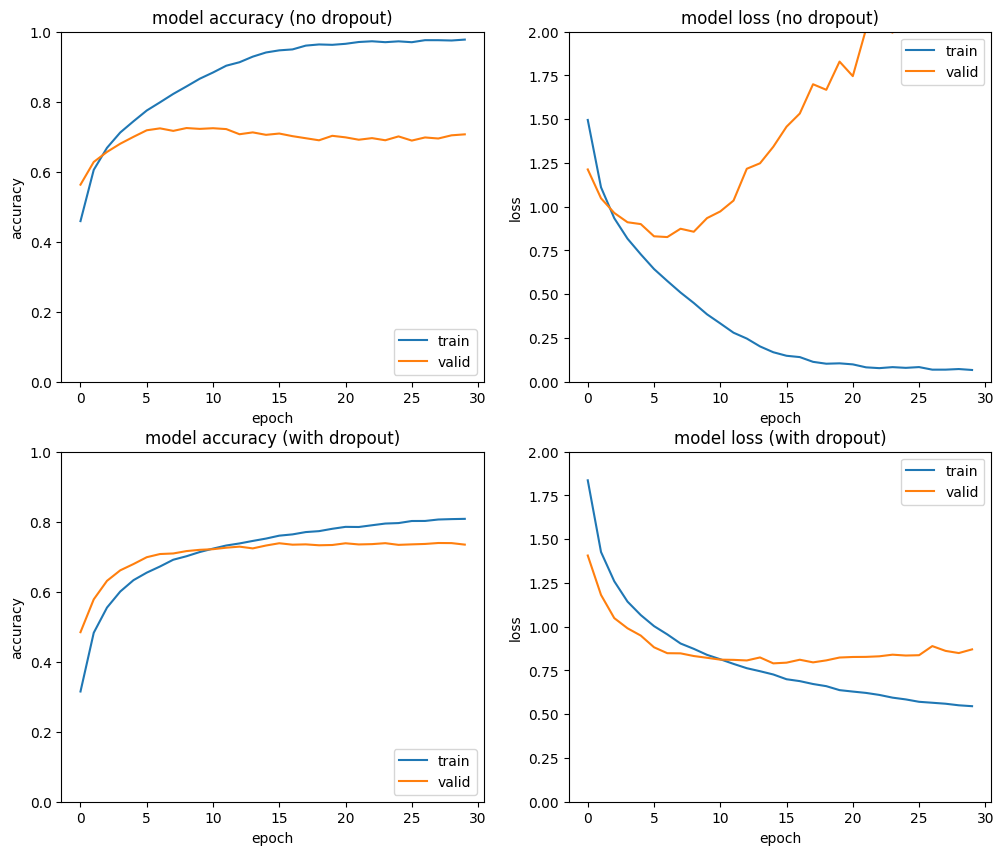

In [19]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.ylim(0, 1)
plt.title('model accuracy (no dropout)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(2,2,2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss (no dropout)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.ylim([0,2])


plt.subplot(2,2,3)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.ylim(0, 1)
plt.title('model accuracy (with dropout)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(2,2,4)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss (with dropout)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.ylim([0,2])
plt.show()

**As you can see the model with the dropout layers has a much nice learning curve. You can see a decreasing traning and validation loss and the curves are not very far apart. In the model without dropout you see overfitting; the validation loss starts to increase again after 7 epochs and the training loss is close to zero after 30 epochs. Note that in addition to the prevention of overfitting, you also even gain better classification accuracy ~73% compared to around ~71% without dropout.**